In [61]:
# -*- coding: utf-8 -*-

"""
Title: Vehicle routing problem
Course: ME44206 Quantitative Methods for Logistics
Authors:
    Stefan Klaassen - 6076947
    Peter Nederveen - 
    Britt van de Geer - 
    Bart Verzijl - 
Last updated: 2025-11-27
Version: 1.0

Usage:
    ../
     ├── AssignmentQ2_Group5_B.py
     └── data_small.txt

Dependencies:
    Python 3.13.7+
    gurobipy

"""

# IMPORTS
#==================================================================================================

from pathlib import Path
from dataclasses import dataclass
from collections.abc import Generator
import math
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch




# MODEL DATA
#==================================================================================================

# CONSTANTS
MAX_TIME = 10000
MAX_BATTERY = 2000
VEHICLES = 4
VEHICLE_PACE = 2
VEHICLE_CAPACITY = 120
VEHICLE_RANGE = 110
VEHICLE_CHARGE_RATE = 1.0
VEHICLE_DISCHARGE_RATE = 1.0

@dataclass
class Node:
    LOC_ID: int
    XCOORD: int
    YCOORD: int
    DEMAND: int
    READYTIME: int
    DUETIME: int
    SERVICETIME: int
    CHARGING: int

def get_node_data() -> list[Node]:
    # In a Jupyter notebook __file__ is not defined, so fall back to the current working directory
    try:
        base_path = Path(__file__).parent
    except NameError:
        base_path = Path.cwd()
    file = base_path / 'data_small.txt'
    data = []
    if not file.exists():
        raise FileNotFoundError(f"Data file not found: {file}")
    with file.open('r') as f:
        for line in f:
            row = [int(v) for v in line.strip().split()]
            instance = Node(*row)
            data.append(instance)
    return data

def build_distance_mat(data: list[Node]) -> list[list[float]]:

    def _euclidean_distance(node1: Node, node2: Node) -> float:
        return math.sqrt( (node2.XCOORD - node1.XCOORD)**2 + (node2.YCOORD - node1.YCOORD)**2 )

    mat = []
    for i, start in enumerate(data):
        row = []
        for j, dest in enumerate(data):
            if i == j:
                row.append(0)
                continue
            row.append(_euclidean_distance(start, dest))
        mat.append(row)
    return mat

node_data = get_node_data()

# SETS
#==================================================================================================

N = range(len(node_data))
V = range(VEHICLES)

# PARAMETERS
#==================================================================================================

c  = VEHICLE_CAPACITY      # Vehicle capacity per vehicle v
d  = build_distance_mat(node_data)          # Distance between node i and j
s  = VEHICLE_PACE           # Velocity of vehicle v
q  = [n.DEMAND for n in node_data]          # Demand at node i
bm = VEHICLE_RANGE         # Maximum battery capacity of vehicle v
bc = VEHICLE_CHARGE_RATE                    # Energy charging rate
bd = VEHICLE_DISCHARGE_RATE                 # Energy discharging rate
bs = [n.CHARGING for n in node_data]        # Charger station at node i
ts = [n.SERVICETIME for n in node_data]     # Minimal service time at node i
tr = [n.READYTIME for n in node_data]       # Ready time at node i
td = [n.DUETIME for n in node_data]         # Due time at node i


# MODEL DEFINITION
#==================================================================================================

# MODEL
model = Model('Vehicle Routing Problem')

# DESISION VARIABLES
tau_a_i = model.addVars(N, lb=0, vtype = GRB.CONTINUOUS, name='τ^a')        # Time of arrival at node i
tau_c_i = model.addVars(N, lb=0, vtype = GRB.CONTINUOUS, name='τ^c')        # Time at node i with charging
tau_w_i = model.addVars(N, lb=0, vtype = GRB.CONTINUOUS, name='τ^w')        # Time at node i without charging
z_iv    = model.addVars(N, V, vtype=GRB.BINARY, name='z')                   # If 1, node is visited by vehicle v 
beta_iv = model.addVars(N, V, lb=0, name='β')                               # Battery level of vehicle v at node i
x_ijv   = model.addVars(N, N, V, vtype=GRB.BINARY, name='x')                # If 1, indicates if vehicle v travels from node i to j


# OBJECTIVE
obj = quicksum(d[i][j] * x_ijv[i, j, v] for i in N for j in N for v in V)
model.setObjective(obj, GRB.MINIMIZE)


# CONSTRAINTS
constraints = {
    'visit_constraint':
    (quicksum(z_iv[i, v] for v in V) == 1 for i in N[1:]),

    'depot_constraint':
    quicksum(z_iv[0, v] for v in V) == VEHICLES,

    'vehicle_capacity_constraint': 
    (quicksum(q[i] * z_iv[i, v] for i in N) <= c for v in V),

    'departure_constraint':  
    (quicksum(x_ijv[i, j, v] for j in N) == quicksum(x_ijv[j, i, v]
        for j in N) for i in N for v in V),

    'departure_constraint(2)':  
    (quicksum(x_ijv[i, j, v] for j in N) == z_iv[i, v] for i in N for v in V),

    'no self loops':
    (x_ijv[i, i, v] == 0 for i in N for v in V),

    'time_constraint(1)':
    (tau_a_i[i] + tau_c_i[i] + tau_w_i[i]  +  (d[i][j] * s) -  MAX_TIME * (1 - x_ijv[i, j, v]) <= tau_a_i[j]
        for i in N for j in N[1:] for v in V),
    
    'time_constraint(2)':
    (tau_a_i[i] + tau_c_i[i] + tau_w_i[i]  +  (d[i][j] * s) +  MAX_TIME * (1 - x_ijv[i, j, v]) >= tau_a_i[j]
        for i in N for j in N[1:] for v in V),

    'end_time_constraint(1)':
    (tau_a_i[i] + tau_c_i[i] + tau_w_i[i] +  (d[i][0] * s) -  MAX_TIME * (1 - x_ijv[i, 0, v]) <= td[0]
        for i in N[1:] for v in V),
    
    'end_time_constraint(2)':
    (tau_a_i[i] + tau_c_i[i] + tau_w_i[i] +  (d[i][0] * s) +  MAX_TIME * (1 - x_ijv[i, 0, v]) >= td[0]
        for i in N[1:] for v in V),

    'time_window_constraint_start':
    (tr[i] <= tau_a_i[i] for i in N),

    'time_window_constraint_end':
    (tau_a_i[i] <= td[i] for i in N),

    'service_time_constraint':
    (tau_c_i[i] + tau_w_i[i] >= ts[i] for i in N),

    'battery_capacity_constraint_bottom':
    ((beta_iv[i, v]      -       (d[i][j] * s * bd)   +    tau_c_i[i] * bc * bs[i])   + (1 - x_ijv[i, j, v]) * MAX_BATTERY      >= 0 
        for i in N for j in N for v in V),

    'battery_capacity_constraint_top':
    ((beta_iv[i, v]      +       tau_c_i[i] * bc * bs[i])   - (1 - x_ijv[i, j, v]) * MAX_BATTERY          <= bm 
        for i in N for j in N for v in V),
    
    'battery_update_constraint':
    (beta_iv[i, v]      -       (d[i][j] * s * bd)   +    tau_c_i[i] * bc * bs[i]   + (1 - x_ijv[i, j, v]) * MAX_BATTERY     >=    beta_iv[j, v]
        for i in N for j in N[1:] for v in V),

    'battery_update_constraint(2)':
    (beta_iv[i, v]      -       (d[i][j] * s * bd)   +    tau_c_i[i] * bc * bs[i]   - (1 - x_ijv[i, j, v]) * MAX_BATTERY     <=    beta_iv[j, v]
        for i in N for j in N[1:] for v in V),

    'initial_battery_constraint':
    (beta_iv[0, v] == bm for v in V),

    'charging_time_constraint':
    (tau_c_i[i] == tau_c_i[i] * bs[i] for i in N),


}

for name, con in constraints.items():
    model.addConstrs(con, name=name) if isinstance(con, Generator) else model.addConstr(con, name=name)

# SOLVE
#==================================================================================================
# model.computeIIS()

# print('IIS written to model.iis')
# # optional: list IIS constraints
# print([c.ConstrName for c in model.getConstrs() if c.IISConstr == 1])


model.update()
model.write('TSPmodel.lp')
setattr(model.Params, 'timeLimit', 3600)
model.optimize()
# model.write('TSPmodel.sol')

res = model.ObjVal if model.Status == GRB.OPTIMAL else "😢"
print('\n'*2, 'Result: ', res, sep='')





Set parameter TimeLimit to value 3600
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  3600

Optimize a model with 10773 rows, 1995 columns and 41463 nonzeros
Model fingerprint: 0xc5c7208b
Variable types: 147 continuous, 1848 integer (1848 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [2e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 6245 rows and 1123 columns
Presolve time: 0.23s
Presolved: 4528 rows, 872 columns, 34384 nonzeros
Variable types: 127 continuous, 745 integer (745 binary)

Root relaxation: objective 3.108857e+02, 353 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De



Solution: [[(0, 14), (12, 0), (14, 15), (15, 16), (16, 12)], [(0, 5), (5, 17), (13, 18), (17, 13), (18, 19), (19, 0)], [(0, 20), (6, 9), (8, 0), (9, 11), (10, 8), (11, 10), (20, 6)], [(0, 3), (1, 7), (2, 1), (3, 2), (4, 0), (7, 4)]]


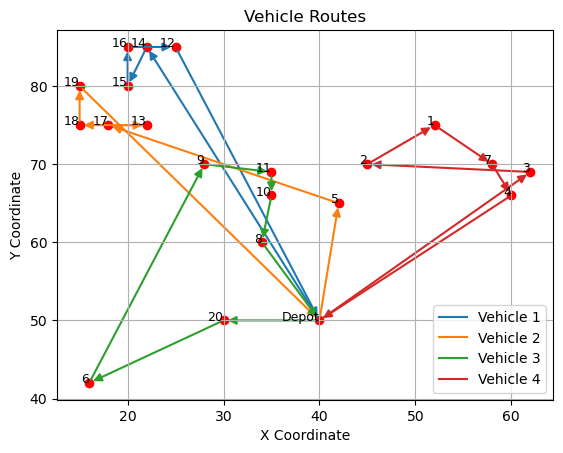

In [62]:
if res != "😢":
    # Extract solution
    solution = []
    for v in V:
        route = []
        for i in N:
            for j in N:
                if x_ijv[i, j, v].X > 0.5:
                    route.append((i, j))
        solution.append(route)
    
    print('\n'*2, 'Solution: ', solution, sep='')

    # Plotting points
    x_coords = [node_data[0].XCOORD]
    y_coords = [node_data[0].YCOORD]
    for n in node_data[1:]:
        x_coords.append(n.XCOORD)
        y_coords.append(n.YCOORD)
    plt.scatter(x_coords, y_coords, color='red')
    plt.text(node_data[0].XCOORD, node_data[0].YCOORD, 'Depot', fontsize=9, ha='right')
    for i, n in enumerate(node_data[1:], start=1):
        plt.text(n.XCOORD, n.YCOORD, f'{i}', fontsize=9, ha='right')


    # Plotting the routes put arrows between the nodes
    cmap = plt.get_cmap('tab10')

    for v, route in enumerate(solution):
        if not route:
            continue
        color = cmap(v % 10)
        plt.plot([], [], color=color, label=f'Vehicle {v+1}')
        ax = plt.gca()
        for i_idx, j_idx in route:
            x1, y1 = node_data[i_idx].XCOORD, node_data[i_idx].YCOORD
            x2, y2 = node_data[j_idx].XCOORD, node_data[j_idx].YCOORD
            if x1 == x2 and y1 == y2:
                continue
            arr = FancyArrowPatch((x1, y1), (x2, y2),
                                 arrowstyle='-|>', mutation_scale=12,
                                 color=color, linewidth=1.5,
                                 shrinkA=3, shrinkB=3)
            ax.add_patch(arr)

    plt.title('Vehicle Routes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid()
    plt.show()



Solution in sequence: [[0, 14, 15, 16, 12, 0], [0, 5, 17, 13, 18, 19, 0], [0, 20, 6, 9, 11, 10, 8, 0], [0, 3, 2, 1, 7, 4, 0]]
Node 0, Vehicle 0: Time Arrival=0, Charging Time=0, Waiting Time=9, Battery Level=110, After Charging=110, charging station=0 
Node 14, Vehicle 0: Time Arrival=88, Charging Time=0, Waiting Time=118, Battery Level=31, After Charging=31, charging station=0 
Node 15, Vehicle 0: Time Arrival=216, Charging Time=76, Waiting Time=792, Battery Level=21, After Charging=96, charging station=1 
Node 16, Vehicle 0: Time Arrival=1094, Charging Time=0, Waiting Time=90, Battery Level=86, After Charging=86, charging station=0 
Node 12, Vehicle 0: Time Arrival=1194, Charging Time=0, Waiting Time=170, Battery Level=76, After Charging=76, charging station=0 
Node 0, Vehicle 1: Time Arrival=0, Charging Time=0, Waiting Time=9, Battery Level=110, After Charging=110, charging station=0 
Node 5, Vehicle 1: Time Arrival=39, Charging Time=0, Waiting Time=376, Battery Level=80, After Ch

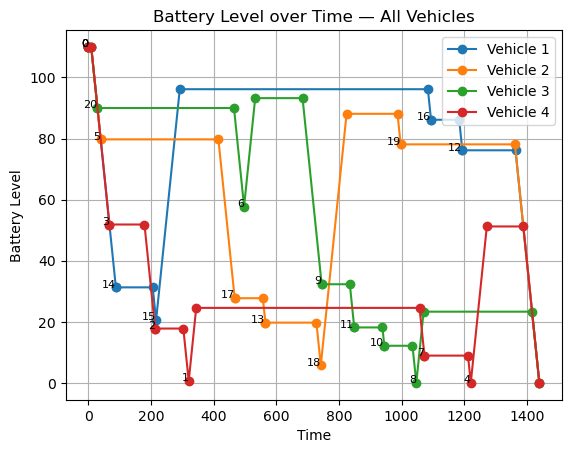



time of arrival: [0, 88, 216, 1094, 1194, 1440, 0, 39, 467, 565, 742, 997, 1440, 0, 29, 497, 745, 849, 945, 1047, 1440, 0, 67, 213, 320, 1073, 1221, 1440]


In [67]:

if res != "😢":
    solution = []
    for v in V:
        route = [0]
        i = 0
        # follow arcs from the depot until we return to depot or no outgoing arc is found
        while True:
            found = False
            for j in N:  # iterate only over valid node indices
                if x_ijv[i, j, v].X > 0.5:
                    if route[-1] != j:
                        route.append(j)
                    i = j
                    found = True
                    break
            # stop if no outgoing arc or we've returned to the depot
            if not found or i == 0:
                break
        solution.append(route)
    
    print('\n'*2, 'Solution in sequence: ', solution, sep='')

    # time of arrival, charging time, waiting time, battery level




plt.figure()
cmap = plt.get_cmap('tab10')
timeofarrival = []
for vehicle, route in enumerate(solution):
    
    if not route:
        continue
    timeofarrival_v = []
    time = []
    battery = []
    for i in route[:-1]:  # Exclude the last node to avoid index error
        timeofarrival_v.append(round(tau_a_i[i].X))
        time.extend([
            tau_a_i[i].X,
            tau_a_i[i].X + tau_c_i[i].X,
            tau_a_i[i].X + tau_c_i[i].X + tau_w_i[i].X
        ])
        battery.extend([
            beta_iv[i, vehicle].X,
            beta_iv[i, vehicle].X + tau_c_i[i].X * bc * bs[i],
            beta_iv[i, vehicle].X + tau_c_i[i].X * bc * bs[i]
        ])
        print(f'Node {i}, Vehicle {round(vehicle)}: Time Arrival={round(tau_a_i[i].X)}, Charging Time={round(tau_c_i[i].X)}, Waiting Time={round(tau_w_i[i].X)}, Battery Level={round(beta_iv[i, vehicle].X)}, After Charging={round(beta_iv[i, vehicle].X + tau_c_i[i].X * bc * bs[i])}, charging station={bs[i]} ')
        plt.text(tau_a_i[i].X, beta_iv[i, vehicle].X, f'{i}', fontsize=8, ha='right')
        last_i = i
    timeofarrival_v.append(round(tau_a_i[last_i].X + tau_c_i[last_i].X    +     tau_w_i[last_i].X + d[last_i][0] * s))
    time.append(tau_a_i[last_i].X + tau_c_i[last_i].X    +     tau_w_i[last_i].X + d[last_i][0] * s)
    battery.append(beta_iv[last_i, vehicle].X     -    d[last_i][0] * s * bd  +  tau_c_i[last_i].X * bc * bs[last_i])
    timeofarrival.extend(timeofarrival_v)

    plt.plot(time, battery, marker='o', color=cmap(vehicle % 10), label=f'Vehicle {vehicle+1}')
plt.title(f'Battery Level over Time — All Vehicles')
plt.xlabel('Time')
plt.ylabel('Battery Level')
plt.legend()
plt.grid()
plt.show()

print('\n'*2,'time of arrival: ' , timeofarrival, sep='')





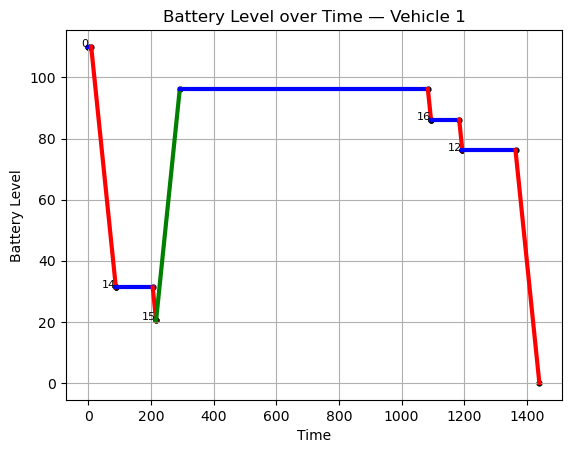

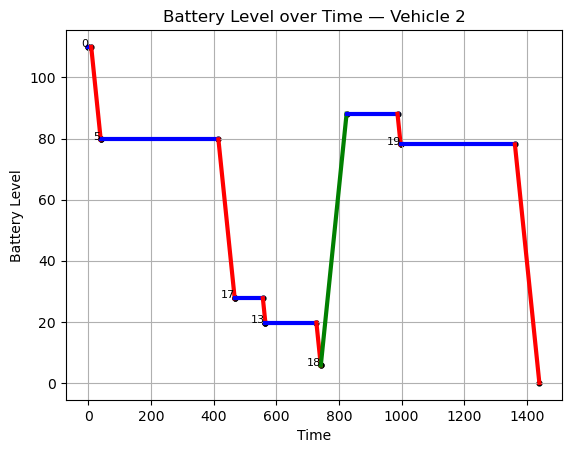

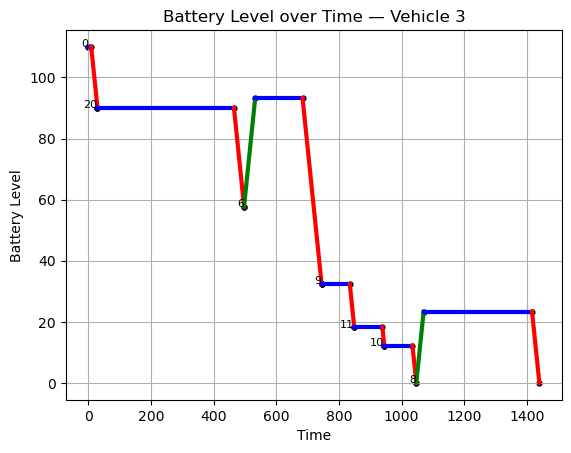

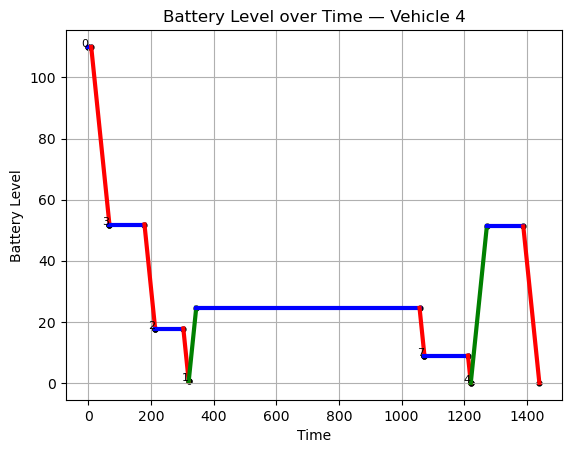

In [64]:
# plot per vehicle: charging (green), waiting (blue), discharging (red)
for vehicle, route in enumerate(solution):
    if not route:
        continue
    plt.figure()
    for idx in range(len(route) - 1):
        i = route[idx]
        j = route[idx + 1]

        # times
        t_arr = tau_a_i[i].X
        t_charge = tau_c_i[i].X
        t_wait = tau_w_i[i].X
        t_depart = t_arr + t_charge + t_wait

        # battery levels at i and after charging at i
        b_arr = beta_iv[i, vehicle].X
        b_after_ch = b_arr + t_charge * bc * bs[i]

        # if next node is depot (0) compute arrival time/battery from travel,
        # otherwise read from model variables
        if j == 0:
            t_arr_j = t_depart + d[i][0] * s
            b_arr_j = b_after_ch - d[i][0] * s * bd
        else:
            t_arr_j = tau_a_i[j].X
            b_arr_j = beta_iv[j, vehicle].X

        # charging segment (ramp up)
        if t_charge > 0:
            plt.plot([t_arr, t_arr + t_charge], [b_arr, b_after_ch], color='green', linewidth=3, label='Charging' if idx == 0 else "")
        # waiting segment (flat)
        if t_wait > 0:
            plt.plot([t_arr + t_charge, t_depart], [b_after_ch, b_after_ch], color='blue', linewidth=3, label='Waiting' if idx == 0 else "")
        # discharging/travel segment (ramp down)
        if t_depart < t_arr_j:
            plt.plot([t_depart, t_arr_j], [b_after_ch, b_arr_j], color='red', linewidth=3, label='Discharging' if idx == 0 else "")

        # annotate key points
        pts_t = [t_arr, t_arr + t_charge, t_depart, t_arr_j]
        pts_b = [b_arr, b_after_ch, b_after_ch, b_arr_j]
        plt.scatter(pts_t, pts_b, color='k', s=12)
        plt.text(t_arr, b_arr, f'{i}', fontsize=8, ha='right')

    plt.title(f'Battery Level over Time — Vehicle {vehicle+1}')
    plt.xlabel('Time')
    plt.ylabel('Battery Level')
    plt.grid()
    plt.show()


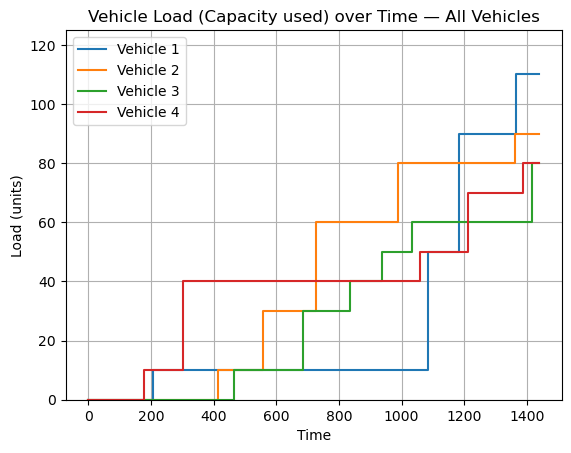

In [66]:
# plot of vehicle capacity (load) over time for all vehicles
# Override plt.step so subsequent calls plot "capacity used" instead of "capacity unused".
# The code below assumes 'loads' in the loop represent unused capacity (start at c and decrease).
_orig_step = plt.step
def _step_capacity_used(times, loads, where='post', **kwargs):
	used = [c - lv for lv in loads]  # convert unused -> used
	return _orig_step(times, used, where=where, **kwargs)
plt.step = _step_capacity_used
if res != "😢":
	plt.figure()
	cmap = plt.get_cmap('tab10')

	for vehicle, route in enumerate(solution):
		if not route:
			continue

		times = []
		loads = []
		load = c  # start with full vehicle capacity

		# record initial depot arrival (usually time 0)
		start_node = route[0]
		t_start = tau_a_i[start_node].X
		times.append(t_start)
		loads.append(load)

		# iterate edges i -> j in the route
		for idx in range(len(route) - 1):
			i = route[idx]
			j = route[idx + 1]

			# times at node i
			t_arr_i = tau_a_i[i].X
			t_charge_i = tau_c_i[i].X
			t_wait_i = tau_w_i[i].X
			t_depart_i = t_arr_i + t_charge_i + t_wait_i

			# arrival at next node j (compute travel when j == 0)
			if j == 0:
				t_arr_j = t_depart_i + d[i][0] * s
			else:
				t_arr_j = tau_a_i[j].X

			# mark departure from i (load unchanged)
			times.append(t_depart_i)
			loads.append(load)

			# mark arrival at j (before unloading)
			times.append(t_arr_j)
			loads.append(load)

			# if j is a customer, unload (reduce load) after service at j
			if j != 0:
				t_after_service_j = t_arr_j + tau_c_i[j].X + tau_w_i[j].X
				new_load = max(0, load - q[j])  # cannot go below 0
				# keep load constant until end of service, then drop
				times.append(t_after_service_j)
				loads.append(new_load)
				load = new_load

		# ensure arrays are sorted in time (they should already be non-decreasing)
		# and plot as step function to show load changes over time
		plt.step(times, loads, where='post', color=cmap(vehicle % 10), label=f'Vehicle {vehicle+1}')

	plt.title('Vehicle Load (Capacity used) over Time — All Vehicles')
	plt.xlabel('Time')
	plt.ylabel('Load (units)')
	plt.ylim(0, c + 5)
	plt.grid(True)
	plt.legend()
	plt.show()
else:
	print("No solution to plot (res == 😢)")
